# Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -Uqq wandb
# !wandb login
# import os
# os.environ['WANDB_ENTITY'] = "capi-bgu"
# os.environ['WANDB_CONSOLE'] = "off"
# os.environ['WANDB_SILENT'] = "true"

     |████████████████████████████████| 1.8MB 8.0MB/s 
     |████████████████████████████████| 133kB 45.2MB/s 
     |████████████████████████████████| 174kB 44.0MB/s 
     |████████████████████████████████| 102kB 12.0MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 


In [ ]:
# In order to import pynput you need to run these files to make virtual env

!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &') # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 1s (704 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!pip install -Uqq git+https://github.com/capi-bgu/oratio.git
!pip install -Uqq imbalanced-learn
!pip install -Uqq pynput==1.6.8
!pip install -Uqq optuna
!pip install -Uqq ipdb
import ipdb

     |████████████████████████████████| 215kB 7.4MB/s 
     |████████████████████████████████| 22.3MB 1.6MB/s 
     |████████████████████████████████| 92kB 5.3MB/s 
     |████████████████████████████████| 184kB 12.4MB/s 
     |████████████████████████████████| 307kB 7.7MB/s 
     |████████████████████████████████| 174kB 14.4MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 112kB 13.1MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 143kB 11.4MB/s 
     |████████████████████████████████| 788kB 9.5MB/s 
     |████████████████████████████████| 368kB 22.3MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.18 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.24.1 which is incompatible.


In [ ]:
!git clone https://github.com/capi-bgu/Research.git
from Research.util.data_loading import *
from Research.util.evaluate import *
from Research.util.tune import *

Cloning into 'Research'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (332/332), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 332 (delta 150), reused 240 (delta 86), pack-reused 0
Receiving objects: 100% (332/332), 744.53 KiB | 19.09 MiB/s, done.
Resolving deltas: 100% (150/150), done.


/usr/local/lib/python3.7/dist-packages/optuna/structs.py:18: FutureWarning:

`structs` is deprecated. Classes have moved to the following modules. `structs.StudyDirection`->`study.StudyDirection`, `structs.StudySummary`->`study.StudySummary`, `structs.FrozenTrial`->`trial.FrozenTrial`, `structs.TrialState`->`trial.TrialState`, `structs.TrialPruned`->`exceptions.TrialPruned`.



# Data

In [ ]:
from sklearn.model_selection import train_test_split

def load_data(path, channels, duration):
  data = load_features(path, channels, duration)
  labels = ["categorical", "valance", "arousal", "dominance", "positive"]
  y = data[labels]
  X = data.drop(columns=["session", "time"]+labels)
  X["dominate_window"] = X["dominate_window"].astype('category').cat.codes.astype(np.uint32)
  X["dominate_task"] = X["dominate_task"].astype('category').cat.codes.astype(np.uint32)
  for column in X:
    if "Turn" in column or \
       "count" in column or \
       "switches" in column or \
       "mode_key" in column or \
       "Direction" in column or \
       "unique_events" in column or \
       "error_corrections" in column:
      X[column] = X[column].astype(np.uint32)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=11)
  return X, X_train, X_test, y, y_train, y_test

In [ ]:
X, X_train, X_test, y, y_train, y_test = load_data("/content/drive/MyDrive/capi/data/public/ron.db", "Mouse", 10)

# Model

## models tuning

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

In [ ]:
from abc import ABC
from optuna.trial import Trial
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

class SklearnTuner(Tuner, ABC):
  def __init__(self, name, X_train, X_test, y_train, y_test, labeling_type):
    super().__init__(project="capi", name=name, monitor="mujority-model-dif_sum",
                      default_params={})
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train[labeling_type]
    self.y_test = y_test[labeling_type]
    self.best_score = float('inf')
    self.best_model = None
    self.weights = None
    self.direction = "minimize"
    
    baseline_preds = self._get_baseline_prediction()
    self.majority_eval = self._get_prediction_score(baseline_preds, self.y_test)

  def objective(self, callbacks=()):
    model = self.build_model()
    model.fit(self.X_train, self.y_train)
    return self.__score_model(model)
  
  def run(self, trials=100, use_logger=False):
    super().run(trials, self.direction, use_logger)

  def get_best_results(self):
    eval = self.__get_model_results(self.best_model)
    eval["model"] = self.name
    return eval
  
  def __score_model(self, model):
    eval = self.__get_model_results(model)
    score = 0
    for param in eval:
      score += self.weights[param] * (self.majority_eval[param] - eval[param])
    
    best = False
    if self.direction == "minimize":
      if score < self.best_score:
        best = True
    elif self.direction == "maximize":
      if score > self.best_score:
        best = True
    if best:    
      self.best_score = score
      self.best_model = model
    return score

  def __get_model_results(self, model):
    predictions = model.predict(self.X_test)
    eval = self._get_prediction_score(predictions, self.y_test)
    return eval

  @abstractmethod
  def build_model(self):
    pass
    
  @abstractmethod
  def show_best_results(self, path_to_save=None):
    pass

  @abstractmethod
  def _get_baseline_prediction(self):
    pass
  
  @abstractmethod
  def _get_prediction_score(self, y_pred, y_true):
    pass

### classification

In [ ]:
import os
import pickle
from abc import ABC

class ClassificationTuner(SklearnTuner, ABC):
  def __init__(self, name, X_train, X_test, y_train, y_test, labeling_type, weights):
    super().__init__(name, X_train, X_test, y_train, y_test, labeling_type)
    self.weights = weights
    self.best_score = float('inf')
    self.direction = "minimize"

  def show_best_results(self, path_to_save=None):
    scores = pd.DataFrame(columns=['model', 'accuracy', 'balanced accuracy',
                                   'precision', 'recall', 'f1 score'])
    majority_eval = self.majority_eval
    majority_eval["model"] = "majority rule"
    scores = scores.append(majority_eval, ignore_index=True)
    
    best_results = self.get_best_results()
    scores = scores.append(best_results, ignore_index=True)

    if path_to_save is not None:
      os.mkdir(f"{path_to_save}/{self.name}")
      with open(f'{path_to_save}/{self.name}/pickled_scores.df', 'wb') as res_file:
        pickle.dump(scores, res_file)
      scores.to_html(f'{path_to_save}/{self.name}/scores.html')
      with open(f'{path_to_save}/{self.name}/model.md', 'wb') as model_file:
        pickle.dump(self.best_model, model_file)
      return

    return scores

  def _get_baseline_prediction(self):
    mode_label = self.y_train.mode()[0]
    baseline_prediction = [mode_label for _ in range(len(self.y_test))]
    return baseline_prediction

  def _get_prediction_score(self, y_pred, y_true):
    return dict(clf_scores(np.array(y_true),np.array(y_pred)))

  @abstractmethod
  def build_model(self):
    pass
  

In [ ]:
labeling_type = "categorical"
weights = {"accuracy":1, "balanced accuracy":0.5, "precision":0, "recall":0, "f1 score":0}
trials = 10

#### linear svm

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

class LinearSVMTuner(ClassificationTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("linear_svm", X_train, X_test, y_train, y_test, labeling_type, weights)

  def build_model(self):
    model = make_pipeline(MinMaxScaler(),
                          LinearSVC(penalty=self.params["penalty"],
                                    loss="squared_hinge",
                                    dual=False,
                                    C=self.params["C"],
                                    multi_class=self.params["multi_class"],
                                    fit_intercept=True,
                                    intercept_scaling=self.params["intercept_scaling"],
                                    class_weight=None,
                                    verbose=0,
                                    random_state=42,
                                    max_iter=50000))
    return model

  def update_params(self, trial: Trial):
    self.params["penalty"] = trial.suggest_categorical("penalty", ["l1", "l2"])
    self.params["multi_class"] = trial.suggest_categorical("multi_class", ["ovr", "crammer_singer"])
    self.params["C"] = trial.suggest_float("C", 0, 1)
    self.params["intercept_scaling"] = trial.suggest_float("intercept_scaling", 0, 10)
  
  def run(self, trials=100, use_logger=False):
    super().run(trials, use_logger)

In [ ]:
lsvm_tuner = LinearSVMTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
lsvm_tuner.run(trials)
lsvm_tuner.show_best_results()

[I 2021-06-07 17:55:43,771] A new study created in memory with name: no-name-60e82838-6558-464f-8aea-e1151df6beb8
[I 2021-06-07 17:55:44,581] Trial 0 finished with value: 0.07677970177970178 and parameters: {'penalty': 'l2', 'multi_class': 'crammer_singer', 'C': 0.2647251104931927, 'intercept_scaling': 7.404991539990849}. Best is trial 0 with value: 0.07677970177970178.
[I 2021-06-07 17:55:44,607] Trial 1 finished with value: -0.052489177489177474 and parameters: {'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.7511670141587344, 'intercept_scaling': 7.326169900229603}. Best is trial 1 with value: -0.052489177489177474.
[I 2021-06-07 17:55:44,626] Trial 2 finished with value: -0.052489177489177474 and parameters: {'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.7261314077012728, 'intercept_scaling': 7.767864030856861}. Best is trial 1 with value: -0.052489177489177474.
[I 2021-06-07 17:55:44,663] Trial 3 finished with value: 0.016774891774891748 and parameters: {'penalty': 'l1', 'multi_clas

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): -0.052489177489177474
	optimized parameters:
		penalty: l2
		multi_class: ovr
		C: 0.7511670141587344
		intercept_scaling: 7.326169900229603
	final parameters:
		penalty: l2
		multi_class: ovr
		C: 0.7511670141587344
		intercept_scaling: 7.326169900229603


,model,accuracy,balanced accuracy,precision,recall,f1 score
0,majority rule,0.318182,0.166667,0.318182,0.318182,0.318182
1,linear_svm,0.340909,0.226190,0.340909,0.340909,0.340909


#### KNeighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

class KNeighborsTuner(ClassificationTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("knn", X_train, X_test, y_train, y_test, labeling_type, weights)
  def build_model(self):
    model = KNeighborsClassifier(n_neighbors=self.params["n_neighbors"], 
                                 weights=self.params["weights"], 
                                 algorithm=self.params["algorithm"],
                                 p=self.params["p"], 
                                 metric=self.params["metric"])
    return model

  def update_params(self, trial: Trial):    
    self.params["n_neighbors"] = trial.suggest_int("n_neighbors", 1,20)
    self.params["weights"] = trial.suggest_categorical("weights", ["uniform", "distance"])
    self.params["algorithm"] = trial.suggest_categorical("algorithm", ["ball_tree", "kd_tree", "brute"])
    self.params["p"] = trial.suggest_int("p", 1,5)
    self.params["metric"] = trial.suggest_categorical("metric", ["euclidean", "manhattan", "chebyshev", "minkowski"])
  
  def run(self, trials=100, use_logger=False):
    super().run(trials, use_logger)

In [ ]:
knn_tuner = KNeighborsTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
knn_tuner.run(trials)
knn_tuner.show_best_results()

[I 2021-06-07 17:55:48,037] A new study created in memory with name: no-name-a1513404-07bc-47e1-a8a1-8365a89dcbe0
[I 2021-06-07 17:55:48,052] Trial 0 finished with value: -0.052489177489177474 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'p': 2, 'metric': 'manhattan'}. Best is trial 0 with value: -0.052489177489177474.
[I 2021-06-07 17:55:48,069] Trial 1 finished with value: -0.025553150553150564 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'brute', 'p': 1, 'metric': 'chebyshev'}. Best is trial 0 with value: -0.052489177489177474.
[I 2021-06-07 17:55:48,084] Trial 2 finished with value: -0.1492424242424243 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 4, 'metric': 'manhattan'}. Best is trial 2 with value: -0.1492424242424243.
[I 2021-06-07 17:55:48,114] Trial 3 finished with value: -0.09296536796536793 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'algorithm': 'brute'

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): -0.1492424242424243
	optimized parameters:
		n_neighbors: 16
		weights: distance
		algorithm: ball_tree
		p: 4
		metric: manhattan
	final parameters:
		n_neighbors: 16
		weights: distance
		algorithm: ball_tree
		p: 4
		metric: manhattan


,model,accuracy,balanced accuracy,precision,recall,f1 score
0,majority rule,0.318182,0.166667,0.318182,0.318182,0.318182
1,knn,0.409091,0.283333,0.409091,0.409091,0.409091


#### DecisionTrees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

class DecisionTreeTuner(ClassificationTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("decision_tree", X_train, X_test, y_train, y_test, labeling_type, weights)
    
  def build_model(self):
    model = DecisionTreeClassifier(criterion=self.params["criterion"], 
                                   splitter=self.params["splitter"], 
                                   max_depth=self.params["max_depth"], 
                                   min_samples_split=self.params["min_samples_split"], 
                                   min_samples_leaf=self.params["min_samples_leaf"],   
                                   max_features=self.params["max_features"],  
                                   random_state=42, 
                                   max_leaf_nodes=self.params["max_leaf_nodes"],  
                                   class_weight=self.params["class_weight"], 
                                   ccp_alpha=self.params["ccp_alpha"])
    return model

  def update_params(self, trial: Trial):
    self.params["criterion"] = trial.suggest_categorical("criterion", ["gini", "entropy"])
    self.params["splitter"] = trial.suggest_categorical("splitter", ["best", "random"])
    self.params["max_depth"] = trial.suggest_int("max_depth", 3,40)
    self.params["min_samples_split"] = trial.suggest_int("min_samples_split", 2,6)
    self.params["min_samples_leaf"] = trial.suggest_int("min_samples_leaf", 2,6)
    self.params["max_features"] = trial.suggest_int("max_features", 1, len(self.X_train.columns))
    self.params["max_leaf_nodes"] = trial.suggest_int("max_leaf_nodes", 2,30)
    self.params["class_weight"] = trial.suggest_categorical("class_weight", [None, "balanced"])
    self.params["ccp_alpha"] = trial.suggest_float("ccp_alpha", 0, 1)
  
  def run(self, trials=300, use_logger=False):
    super().run(trials, use_logger)    

In [ ]:
dt_tuner = DecisionTreeTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
dt_tuner.run(trials)
dt_tuner.show_best_results()

[I 2021-06-07 17:55:48,311] A new study created in memory with name: no-name-df09642c-28ef-461d-adcd-48ee8a33f1fe
[I 2021-06-07 17:55:48,326] Trial 0 finished with value: 0.0 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 16, 'max_leaf_nodes': 19, 'class_weight': None, 'ccp_alpha': 0.2581183968345938}. Best is trial 0 with value: 0.0.
[I 2021-06-07 17:55:48,342] Trial 1 finished with value: 0.0 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 34, 'max_leaf_nodes': 13, 'class_weight': None, 'ccp_alpha': 0.45133653007905616}. Best is trial 0 with value: 0.0.
[I 2021-06-07 17:55:48,358] Trial 2 finished with value: 0.0 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 16, 'max_leaf_nodes': 21, 'class_weight': 'balanced', 

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): 0.0
	optimized parameters:
		criterion: gini
		splitter: random
		max_depth: 13
		min_samples_split: 5
		min_samples_leaf: 3
		max_features: 16
		max_leaf_nodes: 19
		class_weight: None
		ccp_alpha: 0.2581183968345938
	final parameters:
		criterion: gini
		splitter: random
		max_depth: 13
		min_samples_split: 5
		min_samples_leaf: 3
		max_features: 16
		max_leaf_nodes: 19
		class_weight: None
		ccp_alpha: 0.2581183968345938


,model,accuracy,balanced accuracy,precision,recall,f1 score
0,majority rule,0.318182,0.166667,0.318182,0.318182,0.318182
1,decision_tree,0.318182,0.166667,0.318182,0.318182,0.318182


#### Logistic Regression

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

class LogisticRegressionTuner(ClassificationTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("logistic_regression", X_train, X_test, y_train, y_test, labeling_type, weights)
  def build_model(self):
    model = make_pipeline(MinMaxScaler(),
                          LogisticRegression(penalty=self.params["penalty"], 
                                             dual=False, 
                                             tol=self.params["tol"], 
                                             C=self.params["C"], 
                                             fit_intercept=self.params["fit_intercept"], 
                                             intercept_scaling=self.params["intercept_scaling"], 
                                             class_weight=self.params["class_weight"], 
                                             random_state=42, 
                                             solver=self.params["solver"], 
                                             max_iter=25000, 
                                             multi_class=self.params["multi_class"]))
    return model

  def objective(self, callbacks: List[Callback] = ()) -> float:
    if (self.params["solver"] in ["newton-cg", "lbfgs", "saga" , "sag"] and self.params["penalty"] == "l1") or \
       (self.params["solver"] == "liblinear" and self.params["penalty"] == None) or \
       (self.params["solver"] == "liblinear" and self.params["multi_class"] == "multinomial") or \
       (self.params["penalty"] == "elasticnet" and self.params["solver"] != "saga"):
      return float('inf')
    return super().objective(callbacks)

  def update_params(self, trial: Trial):
    self.params["penalty"] = trial.suggest_categorical("penalty", ["l1", "l2"])
    self.params["tol"] = trial.suggest_float("tol", 0, 0.01)
    self.params["C"] = trial.suggest_float("C", 0, 1)
    self.params["fit_intercept"] = trial.suggest_categorical("fit_intercept", [True, False])
    self.params["intercept_scaling"] = trial.suggest_float("intercept_scaling", 0, 2)
    self.params["class_weight"] = trial.suggest_categorical("class_weight", ["balanced", None])
    self.params["solver"] = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear", "sag", "saga"])
    self.params["multi_class"] = trial.suggest_categorical("multi_class", ["ovr", "multinomial"])
  
  def run(self, trials=500, use_logger=False):
    super().run(trials, use_logger)

In [ ]:
lr_tuner = LogisticRegressionTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
lr_tuner.run(trials)
lr_tuner.show_best_results()

[I 2021-06-07 17:55:48,578] A new study created in memory with name: no-name-97d9fcc5-e636-412c-804c-e29b04853490
[I 2021-06-07 17:55:48,615] Trial 0 finished with value: -0.07521645021645024 and parameters: {'penalty': 'l2', 'tol': 0.006487835976073719, 'C': 0.8096868406576713, 'fit_intercept': True, 'intercept_scaling': 0.5511135784946917, 'class_weight': None, 'solver': 'lbfgs', 'multi_class': 'multinomial'}. Best is trial 0 with value: -0.07521645021645024.
[I 2021-06-07 17:55:48,639] Trial 1 finished with value: -0.011904761904761904 and parameters: {'penalty': 'l2', 'tol': 0.0012809926091193714, 'C': 0.716356865766404, 'fit_intercept': False, 'intercept_scaling': 1.7071079433210532, 'class_weight': None, 'solver': 'sag', 'multi_class': 'multinomial'}. Best is trial 0 with value: -0.07521645021645024.
[I 2021-06-07 17:55:48,665] Trial 2 finished with value: -0.07248677248677247 and parameters: {'penalty': 'l2', 'tol': 0.008289643861582208, 'C': 0.05256727141615869, 'fit_intercept'

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): -0.1788961038961039
	optimized parameters:
		penalty: l1
		tol: 0.0027901327681106015
		C: 0.5822298139902389
		fit_intercept: False
		intercept_scaling: 0.713504594943666
		class_weight: balanced
		solver: liblinear
		multi_class: ovr
	final parameters:
		penalty: l1
		tol: 0.0027901327681106015
		C: 0.5822298139902389
		fit_intercept: False
		intercept_scaling: 0.713504594943666
		class_weight: balanced
		solver: liblinear
		multi_class: ovr


,model,accuracy,balanced accuracy,precision,recall,f1 score
0,majority rule,0.318182,0.166667,0.318182,0.318182,0.318182
1,logistic_regression,0.386364,0.388095,0.386364,0.386364,0.386364


#### random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

class RandomForestTuner(ClassificationTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("random_forest", X_train, X_test, y_train, y_test, labeling_type, weights)

  def build_model(self):
    model = RandomForestClassifier(n_estimators=150,
                                    criterion=self.params["criterion"],
                                    min_samples_split=self.params["min_samples_split"],
                                    max_features=self.params["max_features"],
                                    bootstrap=self.params["bootstrap"],
                                    random_state=42,
                                    ccp_alpha=self.params["ccp_alpha"])
    return model

  def update_params(self, trial: Trial):
    self.params["criterion"] = trial.suggest_categorical("criterion", ["gini", "entropy"])
    self.params["min_samples_split"] = trial.suggest_int("min_samples_split", 2, 5)
    self.params["max_features"] = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    self.params["bootstrap"] = trial.suggest_categorical("bootstrap", [True, False])
    self.params["ccp_alpha"] = trial.suggest_float("ccp_alpha", 0, 1)
  
  def run(self, trials=100, use_logger=False):
    super().run(trials, use_logger)

In [ ]:
rf_tuner = RandomForestTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
rf_tuner.run(trials)
rf_tuner.show_best_results()

[I 2021-06-07 17:55:48,891] A new study created in memory with name: no-name-f5bbeab0-05e4-400e-9af5-b2d1cd37736a
[I 2021-06-07 17:55:49,131] Trial 0 finished with value: 0.0 and parameters: {'criterion': 'gini', 'min_samples_split': 4, 'max_features': 'log2', 'bootstrap': False, 'ccp_alpha': 0.35149798743457183}. Best is trial 0 with value: 0.0.
[I 2021-06-07 17:55:49,373] Trial 1 finished with value: 0.0 and parameters: {'criterion': 'gini', 'min_samples_split': 2, 'max_features': 'log2', 'bootstrap': False, 'ccp_alpha': 0.9836930803541721}. Best is trial 0 with value: 0.0.
[I 2021-06-07 17:55:50,365] Trial 2 finished with value: 0.0 and parameters: {'criterion': 'entropy', 'min_samples_split': 4, 'max_features': None, 'bootstrap': False, 'ccp_alpha': 0.39071901985073276}. Best is trial 0 with value: 0.0.
[I 2021-06-07 17:55:50,636] Trial 3 finished with value: 0.0 and parameters: {'criterion': 'gini', 'min_samples_split': 2, 'max_features': 'sqrt', 'bootstrap': True, 'ccp_alpha': 0.

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): -0.00703463203463206
	optimized parameters:
		criterion: entropy
		min_samples_split: 5
		max_features: None
		bootstrap: False
		ccp_alpha: 0.09926105116547357
	final parameters:
		criterion: entropy
		min_samples_split: 5
		max_features: None
		bootstrap: False
		ccp_alpha: 0.09926105116547357


,model,accuracy,balanced accuracy,precision,recall,f1 score
0,majority rule,0.318182,0.166667,0.318182,0.318182,0.318182
1,random_forest,0.295455,0.226190,0.295455,0.295455,0.295455


#### Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier

class BaggingTuner(ClassificationTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("bagging", X_train, X_test, y_train, y_test, labeling_type, weights)

  def build_model(self):
    model = BaggingClassifier(n_estimators=100,
                              max_samples=self.params["max_samples"],
                              max_features=self.params["max_features"],
                              bootstrap=self.params["bootstrap"],
                              bootstrap_features=self.params["bootstrap_features"],
                              random_state=42)
    return model

  def update_params(self, trial: Trial):
    self.params["max_samples"] = trial.suggest_float("max_samples", 0.1, 1.0)
    self.params["max_features"] = trial.suggest_int("max_features", 1,len(self.X_train.columns))
    self.params["bootstrap"] = trial.suggest_categorical("bootstrap", [True, False])
    self.params["bootstrap_features"] = trial.suggest_categorical("bootstrap_features", [True, False])

  def run(self, trials=100, use_logger=False):
    super().run(trials, use_logger)

In [ ]:
bag_tuner = BaggingTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
bag_tuner.run(trials)
bag_tuner.show_best_results()

[I 2021-06-07 17:55:54,453] A new study created in memory with name: no-name-59e8c847-0ac3-4bfc-b757-ca1783968dfa
[I 2021-06-07 17:55:54,640] Trial 0 finished with value: -0.00703463203463206 and parameters: {'max_samples': 0.2436667919080326, 'max_features': 13, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 0 with value: -0.00703463203463206.
[I 2021-06-07 17:55:54,841] Trial 1 finished with value: -0.04166666666666667 and parameters: {'max_samples': 0.9080669050929577, 'max_features': 8, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 1 with value: -0.04166666666666667.
[I 2021-06-07 17:55:55,107] Trial 2 finished with value: -0.07629870129870127 and parameters: {'max_samples': 0.5327370282151771, 'max_features': 33, 'bootstrap': False, 'bootstrap_features': True}. Best is trial 2 with value: -0.07629870129870127.
[I 2021-06-07 17:55:55,303] Trial 3 finished with value: -0.07629870129870127 and parameters: {'max_samples': 0.4566448228107507, 'max_feat

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): -0.13961038961038963
	optimized parameters:
		max_samples: 0.3179009704332707
		max_features: 29
		bootstrap: True
		bootstrap_features: False
	final parameters:
		max_samples: 0.3179009704332707
		max_features: 29
		bootstrap: True
		bootstrap_features: False


,model,accuracy,balanced accuracy,precision,recall,f1 score
0,majority rule,0.318182,0.166667,0.318182,0.318182,0.318182
1,bagging,0.386364,0.309524,0.386364,0.386364,0.386364


#### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

class AdaBoostTuner(ClassificationTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("AdaBoost", X_train, X_test, y_train, y_test, labeling_type, weights)

  def build_model(self):
    model = AdaBoostClassifier(n_estimators=self.params["n_estimators"],
                               learning_rate=self.params["learning_rate"], 
                               algorithm=self.params["algorithm"], 
                               random_state=42)
    return model

  def update_params(self, trial: Trial):
    self.params["n_estimators"] = trial.suggest_int("n_estimators", 10,50)
    self.params["learning_rate"] = trial.suggest_float("learning_rate", 0, 2)
    self.params["algorithm"] = trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"])
    
  def run(self, trials=100, use_logger=False):
    super().run(trials, use_logger)

In [ ]:
adaboo_tuner = AdaBoostTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
adaboo_tuner.run(trials)
adaboo_tuner.show_best_results()

[I 2021-06-07 17:55:56,729] A new study created in memory with name: no-name-fa518e8a-3349-481f-8ac6-9531dca80c63
[I 2021-06-07 17:55:56,786] Trial 0 finished with value: -0.00703463203463206 and parameters: {'n_estimators': 23, 'learning_rate': 0.20596865519670549, 'algorithm': 'SAMME'}. Best is trial 0 with value: -0.00703463203463206.
[I 2021-06-07 17:55:56,834] Trial 1 finished with value: -0.09891774891774892 and parameters: {'n_estimators': 20, 'learning_rate': 1.8528471296385478, 'algorithm': 'SAMME'}. Best is trial 1 with value: -0.09891774891774892.
[I 2021-06-07 17:55:56,924] Trial 2 finished with value: -0.0476190476190476 and parameters: {'n_estimators': 41, 'learning_rate': 1.6919196419961973, 'algorithm': 'SAMME'}. Best is trial 1 with value: -0.09891774891774892.
[I 2021-06-07 17:55:56,956] Trial 3 finished with value: -0.00703463203463206 and parameters: {'n_estimators': 10, 'learning_rate': 0.003262427965572412, 'algorithm': 'SAMME.R'}. Best is trial 1 with value: -0.0

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): -0.16079846079846083
	optimized parameters:
		n_estimators: 30
		learning_rate: 1.926906245186339
		algorithm: SAMME
	final parameters:
		n_estimators: 30
		learning_rate: 1.926906245186339
		algorithm: SAMME


,model,accuracy,balanced accuracy,precision,recall,f1 score
0,majority rule,0.318182,0.166667,0.318182,0.318182,0.318182
1,AdaBoost,0.363636,0.397354,0.363636,0.363636,0.363636


#### GradientBoosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

class GradientBosstingTuner(ClassificationTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("GradientBossting", X_train, X_test, y_train, y_test, labeling_type, weights)

  def build_model(self):
    model = GradientBoostingClassifier(
                                       learning_rate=self.params["learning_rate"],
                                       criterion=self.params["criterion"],
                                       min_samples_split=self.params["min_samples_split"], 
                                       max_depth=self.params["max_depth"],
                                       random_state=42,
                                       max_features=self.params["max_features"],
                                       )
    return model

  def update_params(self, trial: Trial):
    self.params["learning_rate"] = trial.suggest_float("learning_rate", 0, 1)
    self.params["criterion"] = trial.suggest_categorical("criterion", ["friedman_mse", "mse"])
    self.params["min_samples_split"] = trial.suggest_int("min_samples_split", 2,5)
    self.params["max_depth"] = trial.suggest_int("max_depth", 2,20)
    self.params["max_features"] = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
  
  def run(self, trials=300, use_logger=False):
    super().run(trials, use_logger)

In [ ]:
gradboo_tuner = GradientBosstingTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
gradboo_tuner.run(trials)
gradboo_tuner.show_best_results()

[I 2021-06-07 17:55:57,373] A new study created in memory with name: no-name-ca8ece53-9f86-4b24-90a4-b10f56089d1b
[I 2021-06-07 17:55:58,237] Trial 0 finished with value: -0.024891774891774923 and parameters: {'learning_rate': 0.8903194869149827, 'criterion': 'friedman_mse', 'min_samples_split': 4, 'max_depth': 17, 'max_features': 'log2'}. Best is trial 0 with value: -0.024891774891774923.
[I 2021-06-07 17:55:59,824] Trial 1 finished with value: 0.00048100048100048476 and parameters: {'learning_rate': 0.7508827542352928, 'criterion': 'friedman_mse', 'min_samples_split': 4, 'max_depth': 8, 'max_features': None}. Best is trial 0 with value: -0.024891774891774923.
[I 2021-06-07 17:56:00,498] Trial 2 finished with value: -0.11093073593073595 and parameters: {'learning_rate': 0.5890920853531028, 'criterion': 'mse', 'min_samples_split': 3, 'max_depth': 6, 'max_features': 'log2'}. Best is trial 2 with value: -0.11093073593073595.
[I 2021-06-07 17:56:01,158] Trial 3 finished with value: -0.053

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): -0.11093073593073595
	optimized parameters:
		learning_rate: 0.5890920853531028
		criterion: mse
		min_samples_split: 3
		max_depth: 6
		max_features: log2
	final parameters:
		learning_rate: 0.5890920853531028
		criterion: mse
		min_samples_split: 3
		max_depth: 6
		max_features: log2


,model,accuracy,balanced accuracy,precision,recall,f1 score
0,majority rule,0.318182,0.166667,0.318182,0.318182,0.318182
1,GradientBossting,0.363636,0.297619,0.363636,0.363636,0.363636


### regression

In [ ]:
import os
import pickle
from abc import ABC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

class RegressionTuner(SklearnTuner, ABC):
  def __init__(self, name, X_train, X_test, y_train, y_test, labeling_type, weights):
    super().__init__(name, X_train, X_test, y_train, y_test, labeling_type)
    self.weights = weights
    self.best_score = -float('inf')
    self.direction = "maximize"

  def show_best_results(self, path_to_save=None):
    scores = pd.DataFrame(columns=['model', 'mean absolute error',
                                   'mean squared error'])
    majority_eval = self.majority_eval
    majority_eval["model"] = "majority rule"
    scores = scores.append(majority_eval, ignore_index=True)
    
    best_results = self.get_best_results()
    scores = scores.append(best_results, ignore_index=True)
    
    predictions = self.best_model.predict(self.X_test)    
    baseline_predictions = self._get_baseline_prediction()

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(1, 1, 1)

    sns.lineplot(x=list(range(len(self.y_test))), y=predictions, legend='full', label="predictions", ax=ax)
    sns.lineplot(x=list(range(len(self.y_test))), y=baseline_predictions, legend='full', label="baseline", ax=ax)
    sns.lineplot(x=list(range(len(self.y_test))), y=self.y_test, legend='full', label="true value", ax=ax)

    if path_to_save is not None:
      plt.close(fig)
      os.mkdir(f"{path_to_save}/{self.name}")
      fig.savefig(f"{path_to_save}/{self.name}/results.png")
      with open(f'{path_to_save}/{self.name}/pickled_scores.df', 'wb') as res_file:
        pickle.dump(scores, res_file)
      scores.to_html(f'{path_to_save}/{self.name}/scores.html')
      with open(f'{path_to_save}/{self.name}/model.md', 'wb') as model_file:
        pickle.dump(self.best_model, model_file)
      return

    return scores

  def _get_baseline_prediction(self):
    mode_label = self.y_train.mean()
    baseline_prediction = [mode_label for _ in range(len(self.y_test))]
    return baseline_prediction

  def _get_prediction_score(self, y_pred, y_true):
    return dict(reg_scores(np.array(y_true),np.array(y_pred)))

  @abstractmethod
  def build_model(self):
    pass

In [ ]:
labeling_type = "valance"
weights = {"mean absolute error":1,
           "mean squared error":1}
trials = 10

#### Ridge

In [ ]:
from sklearn.linear_model import Ridge

class RidgeTuner(RegressionTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("ridge", X_train, X_test, y_train, y_test, labeling_type, weights)

  def build_model(self):
    model = Ridge(
                  alpha=self.params["alpha"],
                  fit_intercept=self.params["fit_intercept"],
                  normalize=self.params["normalize"],
                  max_iter=25000,
                  solver=self.params["solver"],
                  random_state=42)
    return model

  def update_params(self, trial: Trial):
    self.params["alpha"] = trial.suggest_float("alpha", 1, 50)
    self.params["fit_intercept"] = trial.suggest_categorical("fit_intercept", [True, False])
    self.params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    self.params["tol"] = trial.suggest_float("tol", 1e-5,1e-1)
    self.params["solver"] = trial.suggest_categorical("solver", ["svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"])
  
  def run(self, trials=500, use_logger=False):
    super().run(trials, use_logger)

[I 2021-06-07 17:56:09,248] A new study created in memory with name: no-name-ea814887-8758-441f-a6d3-624e9a0626b2
[I 2021-06-07 17:56:09,308] Trial 0 finished with value: -10.064959163517866 and parameters: {'alpha': 35.06354237501444, 'fit_intercept': False, 'normalize': False, 'tol': 0.09102903308216372, 'solver': 'sag'}. Best is trial 0 with value: -10.064959163517866.
[I 2021-06-07 17:56:09,320] Trial 1 finished with value: -0.7754793194789664 and parameters: {'alpha': 36.588672440552145, 'fit_intercept': False, 'normalize': False, 'tol': 0.032397268644859666, 'solver': 'sparse_cg'}. Best is trial 1 with value: -0.7754793194789664.
[I 2021-06-07 17:56:09,331] Trial 2 finished with value: -0.7119280217905772 and parameters: {'alpha': 8.973304821555304, 'fit_intercept': True, 'normalize': True, 'tol': 0.0748791788900082, 'solver': 'cholesky'}. Best is trial 2 with value: -0.7119280217905772.
[I 2021-06-07 17:56:09,458] Trial 3 finished with value: -10.257962232644626 and parameters: 

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): -0.028714025324134473
	optimized parameters:
		alpha: 46.50562049615292
		fit_intercept: True
		normalize: True
		tol: 0.09134429932783292
		solver: sparse_cg
	final parameters:
		alpha: 46.50562049615292
		fit_intercept: True
		normalize: True
		tol: 0.09134429932783292
		solver: sparse_cg


,model,mean absolute error,mean squared error
0,majority rule,1.055413,1.719623
1,ridge,1.070405,1.733345


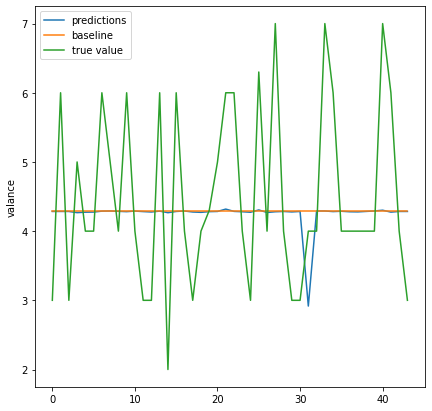

In [ ]:
lr_tuner = RidgeTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
lr_tuner.run(trials)
lr_tuner.show_best_results()

#### Lasso

In [ ]:
from sklearn.linear_model import Lasso

class LassoTuner(RegressionTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("lasso", X_train, X_test, y_train, y_test, labeling_type, weights)

  def build_model(self):
    model = Lasso(alpha=self.params["alpha"],
                  fit_intercept=self.params["fit_intercept"],
                  normalize=self.params["normalize"],
                  max_iter=-1,
                  tol=self.params["tol"],
                  positive=self.params["positive"],
                  random_state=42,
                  selection=self.params["selection"])
    return model

  def update_params(self, trial: Trial):
    self.params["alpha"] = trial.suggest_float("alpha", 0.00001, 1)
    self.params["fit_intercept"] = trial.suggest_categorical("fit_intercept", [True, False])
    self.params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    self.params["tol"] = trial.suggest_float("tol", 1e-6,1e-2)
    self.params["positive"] = trial.suggest_categorical("positive", [True, False])
    self.params["selection"] = trial.suggest_categorical("selection", ["cyclic", "random"])
  
  def run(self, trials=500, use_logger=False):
    super().run(trials, use_logger)

[I 2021-06-07 17:56:10,020] A new study created in memory with name: no-name-112195ff-365e-4486-92d4-83ca2b04da71
[I 2021-06-07 17:56:10,034] Trial 0 finished with value: 4.440892098500626e-16 and parameters: {'alpha': 0.07145755653720627, 'fit_intercept': True, 'normalize': True, 'tol': 0.008605132391943639, 'positive': True, 'selection': 'random'}. Best is trial 0 with value: 4.440892098500626e-16.
[I 2021-06-07 17:56:10,048] Trial 1 finished with value: 4.440892098500626e-16 and parameters: {'alpha': 0.3374902997053791, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015716358627212684, 'positive': True, 'selection': 'random'}. Best is trial 0 with value: 4.440892098500626e-16.
[I 2021-06-07 17:56:10,061] Trial 2 finished with value: 4.440892098500626e-16 and parameters: {'alpha': 0.7646684353639667, 'fit_intercept': True, 'normalize': True, 'tol': 0.005807316960333798, 'positive': True, 'selection': 'random'}. Best is trial 0 with value: 4.440892098500626e-16.
[I 2021-06-07 17:

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): 0.09321747108079648
	optimized parameters:
		alpha: 0.11399116004585032
		fit_intercept: True
		normalize: False
		tol: 0.0032310899826101407
		positive: True
		selection: random
	final parameters:
		alpha: 0.11399116004585032
		fit_intercept: True
		normalize: False
		tol: 0.0032310899826101407
		positive: True
		selection: random


,model,mean absolute error,mean squared error
0,majority rule,1.055413,1.719623
1,lasso,1.040321,1.641498


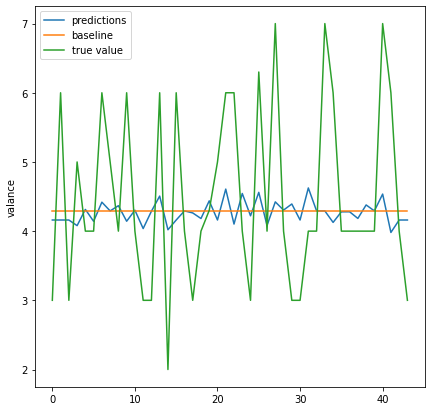

In [ ]:
lasso_tuner = LassoTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
lasso_tuner.run(trials)
lasso_tuner.show_best_results()

#### ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet

class ElasticNetTuner(RegressionTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("ElasticNet", X_train, X_test, y_train, y_test, labeling_type, weights)

  def build_model(self):
    model = ElasticNet(alpha=self.params["alpha"], 
                       l1_ratio=self.params["l1_ratio"], 
                       fit_intercept=self.params["fit_intercept"],
                       normalize=self.params["normalize"],
                       max_iter=-1, 
                       tol=self.params["tol"],
                       positive=self.params["positive"],
                       random_state=42, 
                       selection=self.params["selection"])
    return model

  def update_params(self, trial: Trial):
    self.params["alpha"] = trial.suggest_float("alpha", 0.00001, 1)
    self.params["l1_ratio"] = trial.suggest_float("l1_ratio", 0, 0.1)
    self.params["fit_intercept"] = trial.suggest_categorical("fit_intercept", [True, False])
    self.params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    self.params["tol"] = trial.suggest_float("tol", 1e-6,1e-2)
    self.params["positive"] = trial.suggest_categorical("positive", [True, False])
    self.params["selection"] = trial.suggest_categorical("selection", ["cyclic", "random"])
  
  def run(self, trials=500, use_logger=False):
    super().run(trials, use_logger)

[I 2021-06-07 17:56:10,531] A new study created in memory with name: no-name-98681bdf-c680-4993-b4b4-66f2bb0e2e2d
[I 2021-06-07 17:56:10,595] Trial 0 finished with value: -0.34816173874619327 and parameters: {'alpha': 0.3749719228796075, 'l1_ratio': 0.02378516161936688, 'fit_intercept': False, 'normalize': True, 'tol': 0.00018308799906877627, 'positive': False, 'selection': 'random'}. Best is trial 0 with value: -0.34816173874619327.
[I 2021-06-07 17:56:10,606] Trial 1 finished with value: 4.440892098500626e-16 and parameters: {'alpha': 0.8506725634510286, 'l1_ratio': 0.030269033871431164, 'fit_intercept': True, 'normalize': True, 'tol': 0.006877561419972531, 'positive': True, 'selection': 'random'}. Best is trial 1 with value: 4.440892098500626e-16.
[I 2021-06-07 17:56:10,622] Trial 2 finished with value: -0.20652964576904442 and parameters: {'alpha': 0.19022854542857237, 'l1_ratio': 0.09984332557613854, 'fit_intercept': False, 'normalize': True, 'tol': 0.0060578696354680675, 'positiv

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): 0.19622268224943507
	optimized parameters:
		alpha: 0.5238847101091786
		l1_ratio: 0.0321282888394693
		fit_intercept: True
		normalize: False
		tol: 0.0024133528739917736
		positive: False
		selection: random
	final parameters:
		alpha: 0.5238847101091786
		l1_ratio: 0.0321282888394693
		fit_intercept: True
		normalize: False
		tol: 0.0024133528739917736
		positive: False
		selection: random


,model,mean absolute error,mean squared error
0,majority rule,1.055413,1.719623
1,ElasticNet,1.013111,1.565702


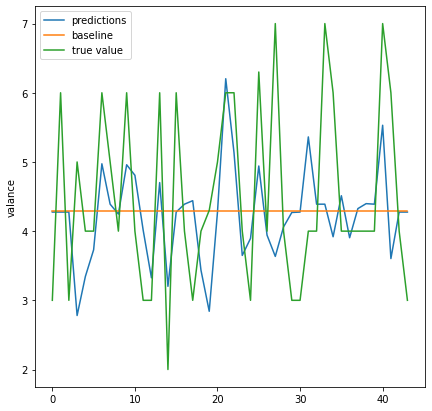

In [ ]:
elastic_tuner = ElasticNetTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
elastic_tuner.run(trials)
elastic_tuner.show_best_results()

#### Lars

In [ ]:
from sklearn.linear_model import Lars

class LarsTuner(RegressionTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("Lars", X_train, X_test, y_train, y_test, labeling_type, weights)
    
  def build_model(self):
    model = Lars(fit_intercept=self.params["fit_intercept"], 
                 normalize=self.params["normalize"],
                 precompute=self.params["precompute"], 
                 n_nonzero_coefs=self.params["n_nonzero_coefs"],
                 eps=self.params["eps"], 
                 jitter=self.params["jitter"], 
                 random_state=42)
    return model

  def update_params(self, trial: Trial):
    self.params["fit_intercept"] = trial.suggest_categorical("fit_intercept", [True, False])
    self.params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    self.params["precompute"] = trial.suggest_categorical("precompute", [True, False])
    self.params["n_nonzero_coefs"] = trial.suggest_int("n_nonzero_coefs", 1, 500)
    self.params["eps"] = trial.suggest_float("eps", 0, 1)
    self.params["jitter"] = trial.suggest_float("jitter", 0, 10)
  
  def run(self, trials=500, use_logger=False):
    super().run(trials, use_logger)

[I 2021-06-07 17:56:11,115] A new study created in memory with name: no-name-1a32749a-7fb5-4aca-a27a-5c24bf903e95
[I 2021-06-07 17:56:11,140] Trial 0 finished with value: -5589602.29533659 and parameters: {'fit_intercept': False, 'normalize': True, 'precompute': False, 'n_nonzero_coefs': 459, 'eps': 0.028565447034830438, 'jitter': 0.8561040472755321}. Best is trial 0 with value: -5589602.29533659.
[I 2021-06-07 17:56:11,180] Trial 1 finished with value: -1097865.7483811795 and parameters: {'fit_intercept': False, 'normalize': True, 'precompute': True, 'n_nonzero_coefs': 349, 'eps': 0.41213900397836023, 'jitter': 8.661269403164718}. Best is trial 1 with value: -1097865.7483811795.
[I 2021-06-07 17:56:11,211] Trial 2 finished with value: -704111.1321917432 and parameters: {'fit_intercept': False, 'normalize': True, 'precompute': True, 'n_nonzero_coefs': 295, 'eps': 0.6743715437046897, 'jitter': 8.237892093778376}. Best is trial 2 with value: -704111.1321917432.
[I 2021-06-07 17:56:11,241

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): -122.41399919805268
	optimized parameters:
		fit_intercept: True
		normalize: True
		precompute: False
		n_nonzero_coefs: 77
		eps: 0.6506361528328659
		jitter: 3.121044869586884
	final parameters:
		fit_intercept: True
		normalize: True
		precompute: False
		n_nonzero_coefs: 77
		eps: 0.6506361528328659
		jitter: 3.121044869586884


,model,mean absolute error,mean squared error
0,majority rule,1.055413,1.719623
1,Lars,3.104290,122.084745


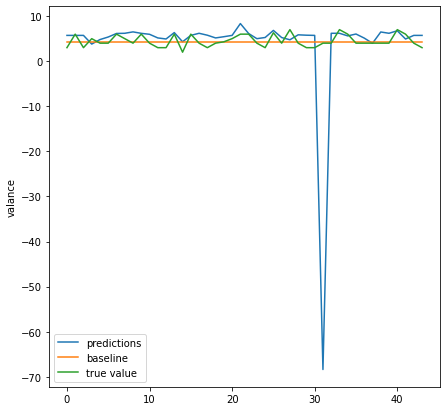

In [ ]:
lars_tuner = LarsTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
lars_tuner.run(trials)
lars_tuner.show_best_results()

#### KNeighbors Regressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

class KNeighborsRegressorTuner(RegressionTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("knn_reg", X_train, X_test, y_train, y_test, labeling_type, weights)
    
  def build_model(self):
    model = KNeighborsRegressor(n_neighbors=self.params["n_neighbors"],
                                weights=self.params["weights"],
                                algorithm=self.params["algorithm"],
                                p=self.params["p"],
                                metric=self.params["metric"])
    return model

  def update_params(self, trial: Trial):
    super().update_params(trial)
    self.params["n_neighbors"] = trial.suggest_int("n_neighbors", 1,40)
    self.params["weights"] = trial.suggest_categorical("weights", ["uniform", "distance"])
    self.params["algorithm"] = trial.suggest_categorical("algorithm", ["ball_tree", "kd_tree", "brute"])
    self.params["p"] = trial.suggest_int("p", 1,5)
    self.params["metric"] = trial.suggest_categorical("metric", ["euclidean", "manhattan", "chebyshev", "minkowski"])
  
  def run(self, trials=300, use_logger=False):
    super().run(trials, use_logger)

[I 2021-06-07 17:56:11,781] A new study created in memory with name: no-name-2649ccde-551b-454a-984f-6e0acd8651b9
[I 2021-06-07 17:56:11,793] Trial 0 finished with value: -0.3584867329953616 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'ball_tree', 'p': 3, 'metric': 'manhattan'}. Best is trial 0 with value: -0.3584867329953616.
[I 2021-06-07 17:56:11,818] Trial 1 finished with value: 0.09303460923581386 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'algorithm': 'brute', 'p': 5, 'metric': 'minkowski'}. Best is trial 1 with value: 0.09303460923581386.
[I 2021-06-07 17:56:11,829] Trial 2 finished with value: 0.2690217985700377 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'algorithm': 'brute', 'p': 3, 'metric': 'manhattan'}. Best is trial 2 with value: 0.2690217985700377.
[I 2021-06-07 17:56:11,850] Trial 3 finished with value: 0.26222086715763626 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 1, 

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): 0.2880318620459612
	optimized parameters:
		n_neighbors: 11
		weights: uniform
		algorithm: ball_tree
		p: 4
		metric: manhattan
	final parameters:
		n_neighbors: 11
		weights: uniform
		algorithm: ball_tree
		p: 4
		metric: manhattan


,model,mean absolute error,mean squared error
0,majority rule,1.055413,1.719623
1,knn_reg,1.010124,1.476880


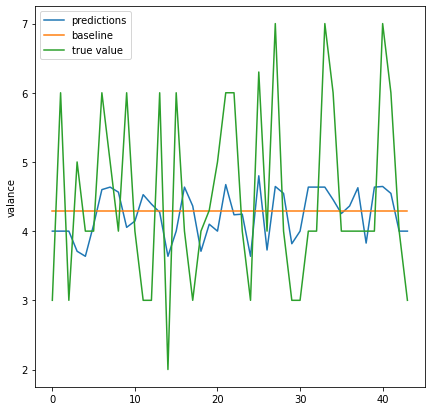

In [ ]:
knn_reg_tuner = KNeighborsRegressorTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
knn_reg_tuner.run(trials)
knn_reg_tuner.show_best_results()

#### SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

class SVRTuner(RegressionTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("svr", X_train, X_test, y_train, y_test, labeling_type, weights)

  def build_model(self):
    model = make_pipeline(MinMaxScaler(),
                          SVR(
                              kernel=self.params["kernel"],
                              degree=self.params["degree"],
                              gamma=self.params["gamma"],
                              coef0=self.params["coef0"],
                              C=self.params["C"],
                              epsilon=self.params["epsilon"],
                              max_iter= 200000))
    return model

  def update_params(self, trial: Trial):
    self.params["kernel"] = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    self.params["degree"] = trial.suggest_int("degree", 2, 10)
    self.params["gamma"] = trial.suggest_float("gamma", 0, 1)
    self.params["coef0"] = trial.suggest_float("coef0", 0, 1)
    self.params["C"] = trial.suggest_float("C", 0, 1)
    self.params["epsilon"] = trial.suggest_float("epsilon", 0.01, 0.1)
  
  def run(self, trials=500, use_logger=False):
    super().run(trials, use_logger)

[I 2021-06-07 17:56:12,288] A new study created in memory with name: no-name-9e1c0e21-0e1f-49d8-ab82-ac67e26e42a1
[I 2021-06-07 17:56:12,313] Trial 0 finished with value: -6.778414457260504e+26 and parameters: {'kernel': 'poly', 'degree': 7, 'gamma': 0.6978422391850534, 'coef0': 0.15849331926662558, 'C': 0.1850763575791875, 'epsilon': 0.05310950747878008}. Best is trial 0 with value: -6.778414457260504e+26.
[I 2021-06-07 17:56:12,335] Trial 1 finished with value: -1.0479571237166043e+33 and parameters: {'kernel': 'poly', 'degree': 9, 'gamma': 0.6614758740771121, 'coef0': 0.7681461599488758, 'C': 0.0014039633231720527, 'epsilon': 0.0791232548275029}. Best is trial 0 with value: -6.778414457260504e+26.
[I 2021-06-07 17:56:12,353] Trial 2 finished with value: -6.889562867898276e+27 and parameters: {'kernel': 'poly', 'degree': 8, 'gamma': 0.31465650129473344, 'coef0': 0.7056241827695653, 'C': 0.05834640928627233, 'epsilon': 0.04234719813872894}. Best is trial 0 with value: -6.7784144572605

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): 0.21325271456904116
	optimized parameters:
		kernel: rbf
		degree: 10
		gamma: 0.975360542519833
		coef0: 0.9113601593374319
		C: 0.7074485670083331
		epsilon: 0.04375480296592405
	final parameters:
		kernel: rbf
		degree: 10
		gamma: 0.975360542519833
		coef0: 0.9113601593374319
		C: 0.7074485670083331
		epsilon: 0.04375480296592405


,model,mean absolute error,mean squared error
0,majority rule,1.055413,1.719623
1,svr,0.944230,1.617553


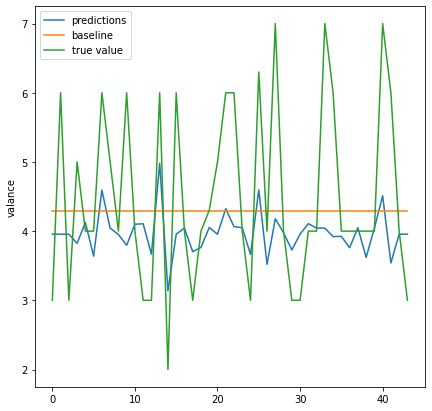

In [ ]:
svr_tuner = SVRTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
svr_tuner.run(trials)
svr_tuner.show_best_results()

#### Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

class RandomForestRegressorTuner(RegressionTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("random_forest_reg", X_train, X_test, y_train, y_test, labeling_type, weights)

  def build_model(self):
    model = RandomForestRegressor(
                                  n_estimators=150,
                                  criterion=self.params["criterion"],
                                  max_depth=self.params["max_depth"],
                                  min_samples_split=self.params["min_samples_split"],
                                  max_features=self.params["max_features"],
                                  bootstrap=self.params["bootstrap"],
                                  random_state=42,
                                  ccp_alpha=self.params["ccp_alpha"]
                                  )
    return model

  def update_params(self, trial: Trial):
    self.params["criterion"] = trial.suggest_categorical("criterion", ["mse", "mae"])
    self.params["max_depth"] = trial.suggest_int("max_depth", 2,50)
    self.params["min_samples_split"] = trial.suggest_int("min_samples_split", 2,5)
    self.params["max_features"] = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    self.params["bootstrap"] = trial.suggest_categorical("bootstrap", [True, False])
    self.params["ccp_alpha"] = trial.suggest_float("ccp_alpha", 0, 0.1)
  
  def run(self, trials=500, use_logger=False):
    super().run(trials, use_logger)

[I 2021-06-07 17:56:12,828] A new study created in memory with name: no-name-5d1803f5-8f76-4589-9811-339bcca311f3
[I 2021-06-07 17:56:13,063] Trial 0 finished with value: 0.18715181006525716 and parameters: {'criterion': 'mse', 'max_depth': 17, 'min_samples_split': 2, 'max_features': 'log2', 'bootstrap': False, 'ccp_alpha': 0.07426319673933413}. Best is trial 0 with value: 0.18715181006525716.
[I 2021-06-07 17:56:16,329] Trial 1 finished with value: -0.133600369358998 and parameters: {'criterion': 'mae', 'max_depth': 20, 'min_samples_split': 3, 'max_features': None, 'bootstrap': False, 'ccp_alpha': 0.089288996382688}. Best is trial 0 with value: 0.18715181006525716.
[I 2021-06-07 17:56:16,570] Trial 2 finished with value: 0.2646274776408597 and parameters: {'criterion': 'mse', 'max_depth': 14, 'min_samples_split': 3, 'max_features': 'sqrt', 'bootstrap': True, 'ccp_alpha': 0.06365835324793036}. Best is trial 2 with value: 0.2646274776408597.
[I 2021-06-07 17:56:16,766] Trial 3 finished 

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): 0.2990860409852011
	optimized parameters:
		criterion: mse
		max_depth: 16
		min_samples_split: 3
		max_features: log2
		bootstrap: True
		ccp_alpha: 0.0596920819227759
	final parameters:
		criterion: mse
		max_depth: 16
		min_samples_split: 3
		max_features: log2
		bootstrap: True
		ccp_alpha: 0.0596920819227759


,model,mean absolute error,mean squared error
0,majority rule,1.055413,1.719623
1,random_forest_reg,0.979764,1.496186


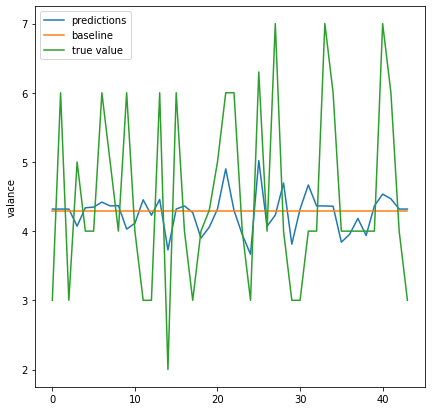

In [ ]:
rfr_tuner = RandomForestRegressorTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
rfr_tuner.run(trials)
rfr_tuner.show_best_results()

#### Bagging Regeressor

In [ ]:
from sklearn.ensemble import BaggingRegressor

class BaggingRegressorTuner(RegressionTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("bagging_reg", X_train, X_test, y_train, y_test, labeling_type, weights)

  def build_model(self):
    model = BaggingRegressor(
                              n_estimators=self.params["n_estimators"],
                              max_samples=self.params["max_samples"],
                              max_features=self.params["max_features"],
                              bootstrap=self.params["bootstrap"],
                              bootstrap_features=self.params["bootstrap_features"],
                              random_state=42)
    return model

  def update_params(self, trial: Trial):
    self.params["n_estimators"] = trial.suggest_int("n_estimators", 50,150)
    self.params["max_samples"] = trial.suggest_float("max_samples", 0.1 ,1)
    self.params["max_features"] = trial.suggest_int("max_features", 1, len(self.X_train.columns))
    self.params["bootstrap"] = trial.suggest_categorical("bootstrap", [True, False])
    self.params["bootstrap_features"] = trial.suggest_categorical("bootstrap_features", [True, False])
  
  def run(self, trials=500, use_logger=False):
    super().run(trials, use_logger)

[I 2021-06-07 17:56:21,724] A new study created in memory with name: no-name-75065e7a-7db7-4200-9809-c13af725dd88
[I 2021-06-07 17:56:21,852] Trial 0 finished with value: -0.01718319146948799 and parameters: {'n_estimators': 50, 'max_samples': 0.9986999529350202, 'max_features': 12, 'bootstrap': False, 'bootstrap_features': True}. Best is trial 0 with value: -0.01718319146948799.
[I 2021-06-07 17:56:21,986] Trial 1 finished with value: 0.17551290548670195 and parameters: {'n_estimators': 55, 'max_samples': 0.9327090226063475, 'max_features': 17, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 1 with value: 0.17551290548670195.
[I 2021-06-07 17:56:22,250] Trial 2 finished with value: 0.22871692803806698 and parameters: {'n_estimators': 128, 'max_samples': 0.5596018316852596, 'max_features': 32, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 2 with value: 0.22871692803806698.
[I 2021-06-07 17:56:22,442] Trial 3 finished with value: 0.003860318548818409 and 

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): 0.23461870676952445
	optimized parameters:
		n_estimators: 136
		max_samples: 0.13564952180913764
		max_features: 10
		bootstrap: False
		bootstrap_features: True
	final parameters:
		n_estimators: 136
		max_samples: 0.13564952180913764
		max_features: 10
		bootstrap: False
		bootstrap_features: True


,model,mean absolute error,mean squared error
0,majority rule,1.055413,1.719623
1,bagging_reg,1.017623,1.522794


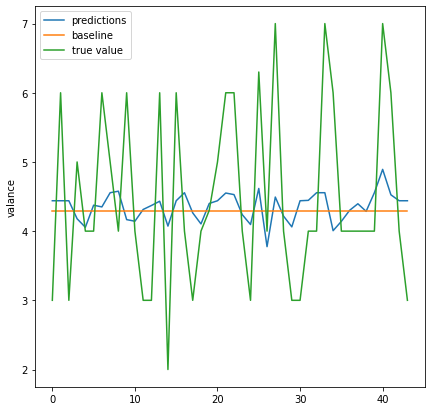

In [ ]:
bagreg_tuner = BaggingRegressorTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
bagreg_tuner.run(trials)
bagreg_tuner.show_best_results()

#### AdaBoost Regressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

class AdaBoostRegressionTuner(RegressionTuner):
  def __init__(self, X_train, X_test, y_train, y_test, labeling_type,
               weights={"accuracy":1, "balanced accuracy":1, "precision":1,
                        "recall":1, "f1 score":1}):
    super().__init__("AdaBoost_reg", X_train, X_test, y_train, y_test, labeling_type, weights)

  def build_model(self):
    model = AdaBoostRegressor(n_estimators=self.params["n_estimators"],
                              learning_rate=self.params["learning_rate"], 
                              loss=self.params["loss"],
                              random_state=42)
    return model

  def update_params(self, trial: Trial):
    self.params["n_estimators"] = trial.suggest_int("n_estimators", 10,100)
    self.params["learning_rate"] = trial.suggest_float("learning_rate", 0, 2)
    self.params["loss"] = trial.suggest_categorical("loss", ["linear", "square", "exponential"])
  
  def run(self, trials=500, use_logger=False):
    super().run(trials, use_logger)

[I 2021-06-07 17:56:23,817] A new study created in memory with name: no-name-0ff09079-8bc0-472a-878e-1ad14b8b0f63
[I 2021-06-07 17:56:23,855] Trial 0 finished with value: -0.21198272632534731 and parameters: {'n_estimators': 34, 'learning_rate': 1.64062303177016, 'loss': 'linear'}. Best is trial 0 with value: -0.21198272632534731.
[I 2021-06-07 17:56:23,967] Trial 1 finished with value: 0.20075043331712372 and parameters: {'n_estimators': 53, 'learning_rate': 0.3046604164705582, 'loss': 'exponential'}. Best is trial 1 with value: 0.20075043331712372.
[I 2021-06-07 17:56:24,077] Trial 2 finished with value: 0.21254380712628107 and parameters: {'n_estimators': 53, 'learning_rate': 0.2855299701824803, 'loss': 'square'}. Best is trial 2 with value: 0.21254380712628107.
[I 2021-06-07 17:56:24,151] Trial 3 finished with value: 0.24904845561749966 and parameters: {'n_estimators': 31, 'learning_rate': 0.048980391946769064, 'loss': 'exponential'}. Best is trial 3 with value: 0.24904845561749966

hyperparameter optimization results:
	number of trials: 10
	number of pruned trials: 0
	best value (mujority-model-dif_sum): 0.31897217578025594
	optimized parameters:
		n_estimators: 85
		learning_rate: 0.11140520467076787
		loss: exponential
	final parameters:
		n_estimators: 85
		learning_rate: 0.11140520467076787
		loss: exponential


,model,mean absolute error,mean squared error
0,majority rule,1.055413,1.719623
1,AdaBoost_reg,1.006665,1.449399


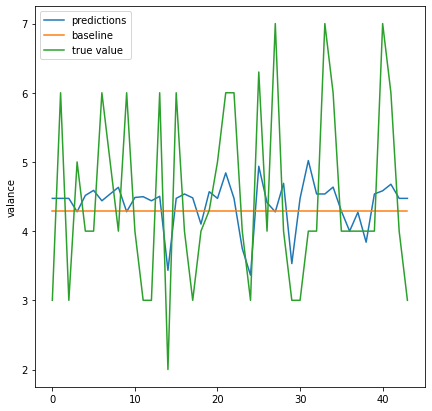

In [ ]:
adareg_tuner = AdaBoostRegressionTuner(X_train, X_test, y_train, y_test, labeling_type, weights)
adareg_tuner.run(trials)
adareg_tuner.show_best_results()

## evaluation

In [ ]:
import os
from sklearn.ensemble import VotingClassifier, VotingRegressor

def get_best_models(tuners, X_train, X_test, y_train, y_test,
                    labeling_type, weights, path_to_save, verbose=False):
  optuna.logging.set_verbosity(optuna.logging.FATAL)
  if verbose:
    optuna.logging.set_verbosity(optuna.logging.INFO)

  untrained_best_models = {}
  if labeling_type == "categorical" or labeling_type == "positive":
    task = "classification"
    majority = y_train[labeling_type].mode()[0]
    majority_predictions = [majority for _ in range(len(y_test[labeling_type]))]
    majority_eval = dict(clf_scores(np.array(y_test[labeling_type]),np.array(majority_predictions)))
  else:
    task = "regression"
    majority = y_train[labeling_type].mean()
    majority_predictions = [majority for _ in range(len(y_test[labeling_type]))]
    majority_eval = dict(reg_scores(np.array(y_test[labeling_type]),np.array(majority_predictions)))

  for tuner in tuners:
    tuner = tuner(X_train, X_test, y_train, y_test, labeling_type, weights)
    print(f"~~~~~~~~~~~~~~~~~~~~{tuner.name}~~~~~~~~~~~~~~~~~~~~")
    tuner.run(use_logger=False) 
    if tuner.best_model is not None:
      untrained_best_models[tuner.name] = tuner.build_model()
      tuner.show_best_results(path_to_save)

  print(f"~~~~~~~~~~~~~~~~~~~~voting~~~~~~~~~~~~~~~~~~~~")
  estimators = list(untrained_best_models.items())
  if task == "classification":
    voting_model = VotingClassifier(estimators, voting='hard', weights=None, 
                                    n_jobs=-1, flatten_transform=True, 
                                    verbose=False)
    voting_model.fit(X_train, y_train[labeling_type])
    voting_preds = voting_model.predict(X_test)
    voting_eval = dict(clf_scores(np.array(y_test[labeling_type]),np.array(voting_preds)))
    measurements = ["model", "accuracy",	"balanced accuracy", "precision", "recall", "f1 score"]
  elif task == "regression":
    voting_model = VotingRegressor(estimators, weights=None, n_jobs=-1, verbose=False)
    voting_model.fit(X_train, y_train[labeling_type])
    voting_preds = voting_model.predict(X_test)
    voting_eval = dict(reg_scores(np.array(y_test[labeling_type]),np.array(voting_preds)))
    measurements = ["model", "mean absolute error", "mean squared error"]

  os.mkdir(f"{path_to_save}/voting")
  voting_scores = pd.DataFrame(columns=measurements)
  majority_eval["model"] = "majority rule"
  voting_scores = voting_scores.append(majority_eval, ignore_index=True)
  voting_eval["model"] = "voting ensamble"
  voting_scores = voting_scores.append(voting_eval, ignore_index=True)

  if task == "regression":
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(1, 1, 1)
    sns.lineplot(x=list(range(len(y_test[labeling_type]))), y=voting_preds, legend='full', label="predictions", ax=ax)
    sns.lineplot(x=list(range(len(y_test[labeling_type]))), y=majority_predictions, legend='full', label="baseline", ax=ax)
    sns.lineplot(x=list(range(len(y_test[labeling_type]))), y=y_test[labeling_type], legend='full', label="true value", ax=ax)
    plt.close(fig)
    fig.savefig(f"{path_to_save}/voting/results.png")

  with open(f'{path_to_save}/voting/pickled_scores.df', 'wb') as res_file:
    pickle.dump(voting_scores, res_file)
  voting_scores.to_html(f'{path_to_save}/voting/scores.html')
  with open(f'{path_to_save}/voting/model.md', 'wb') as model_file:
    pickle.dump(voting_model, model_file)